In [ ]:
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-2.0-flash-001")

# Built-in tools

An example of using a search engine as a tool. Let's create one based on DuckDuckGo search and explore its name, description and arguments' schema:

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()
print(f"Tool's name = {search.name}")
print(f"Tool's name = {search.description}")
print(f"Tool's arg schema = {search.args_schema}")

Tool's name = duckduckgo_search
Tool's name = A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.
Tool's arg schema = <class 'langchain_community.tools.ddg_search.tool.DDGInput'>


In [5]:
from langchain_community.tools.ddg_search.tool import DDGInput

print(DDGInput.__fields__)

{'query': FieldInfo(annotation=str, required=True, description='search query to look up')}


Let's run the tool:

In [6]:
query = "What is the weather in Munich like tomorrow?"
search_input = DDGInput(query=query)
result = search.invoke(search_input.dict())
print(result)

Detailed weather forecast ⚡ in Munich, Bavaria today, tomorrow and 7 days. Wind, precipitation, 🌡️ air temperature, clouds and atmospheric pressure - World-Weather.info ... weather in Munich +57°F. Clear sky, Light Breeze, Northeast 4.5 mph. Atmosphere pressure 28.2 inHg. ... feels like +34°F. The warmest day will be on Thursday, 13 ... The temperature in Munich tomorrow in the early morning is 3 ° C.. If you take into account factors such as wind, humidity and other weather conditions, the temperatures can feel like 1 ° C.. The chance of rain in Munich in the morning is 0%, and the wind will blow at 5 km/h. Munich Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the Munich area. ... Tomorrow will be 3 minutes ... Get the latest hourly weather updates for Bavaria tomorrow. Detailed forecast including temperature, wind, rain, snow, and UV index. ... Forecast March April Annual Today Tomorrow Hist

Now let's enhance an LLM with this tool:

In [15]:
result = llm.invoke([("system", "Always use a duckduckgo_search tool for queries that require a fresh information"), ("user", query)], tools=[search])
print(result.tool_calls[0])

{'name': 'duckduckgo_search', 'args': {'query': 'weather in Munich tomorrow'}, 'id': '1477289e-559b-493a-9228-416fd567087d', 'type': 'tool_call'}


And we can double-check that the model invokes a search tool only when needed:

In [18]:
result = llm.invoke([("system", "Always use a duckduckgo_search tool for queries that require a fresh information"), ("user", "How much is 2+2?")], tools=[search])
assert not result.tool_calls

And we can create a ReACT agent that uses this tool, and explore its workflow graph:

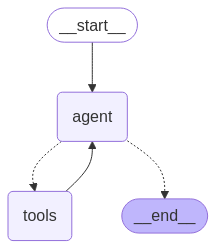

In [21]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

agent = create_react_agent(
  model=llm,
  tools=[search],
  state_modifier="Always use a duckduckgo_search tool for queries that require a fresh information"
)

display(Image(agent.get_graph().draw_mermaid_png()))

If we run it, we can see the tool calls appearing during execution:

In [22]:
for event in agent.stream({"messages": [("user", query)]}):
  messages = event.get("agent", event.get("tools", {})).get("messages", [])
  for m in messages:
     m.pretty_print()


================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (0e746ee3-a54d-418a-a9b5-c9cbe57e2094)
 Call ID: 0e746ee3-a54d-418a-a9b5-c9cbe57e2094
  Args:
    query: weather in Munich tomorrow
================================= Tool Message =================================
Name: duckduckgo_search

Daily weather forecast. Today, 08 March, weather in Munich +57°F. Clear sky, Light Breeze, Northeast 4.5 mph. Atmosphere pressure 28.2 inHg. Relative humidity 33%. Tomorrow's night air temperature will drop to +41°F, wind will change to South 2.7 mph. Pressure will go down and amount to 28 inHg. The temperature in Munich tomorrow in the early morning is 3 ° C.. If you take into account factors such as wind, humidity and other weather conditions, the temperatures can feel like 1 ° C.. The chance of rain in Munich in the morning is 0%, and the wind will blow at 5 km/h. Munich Weather Forecasts. Weather Underground provides local & long-range w

We can also create a tool ourselves from other building blocks:

In [23]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
python_repl.run("print(2**4)")

code_interpreter_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

This is a famous failure of an LLM:

In [44]:
llm = ChatVertexAI(model="gemini-2.0-flash-001", temperature=2.0)

In [47]:
query_strawberry = "How many r are in the word strawberry?"
print(llm.invoke(query_strawberry).content)

There are three "r"s in the word "strawberry".



But we can see that ReACT agent easily solved this problem by invoking an external tool:

In [48]:
agent = create_react_agent(
  model=llm,
  tools=[code_interpreter_tool])

for event in agent.stream({"messages": [("user", query_strawberry)]}):
  messages = event.get("agent", event.get("tools", {})).get("messages", [])
  for m in messages:
     m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  python_repl (2e49bca7-977e-418e-b8df-124f263ff4ec)
 Call ID: 2e49bca7-977e-418e-b8df-124f263ff4ec
  Args:
    __arg1: print('strawberry'.count('r'))
================================= Tool Message =================================
Name: python_repl

3

================================== Ai Message ==================================

There are 3 r's in the word strawberry.


We can also use any third-pary API by wrapping it a tool. But first, we need to define a schema (below is an example for an open-sourced [exchange rates API](https://api.frankfurter.dev/v1)):

In [49]:
api_spec = """
openapi: 3.0.0
info:
  title: Frankfurter Currency Exchange API
  version: v1
  description: API for retrieving currency exchange rates. Pay attention to the base currency and change it if needed.

servers:
  - url: https://api.frankfurter.dev/v1

paths:
  /v1/{date}:
    get:
      summary: Get exchange rates for a specific date.
      parameters:
        - in: path
          name: date
          schema:
            type: string
            pattern: '^\d{4}-\d{2}-\d{2}$' # YYYY-MM-DD format
          required: true
          description: The date for which to retrieve exchange rates.  Use YYYY-MM-DD format.  Example: 2009-01-04
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: GBP,USD,EUR

  /v1/latest:
    get:
      summary: Get the latest exchange rates.
      parameters:
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: CHF,GBP
        - in: query
          name: base
          schema:
            type: string
          description: The base currency for the exchange rates. If not provided, EUR is used as a base currency. Example: USD
"""

We can wrap it with an out-of-the-box `TextRequestsWrapper`:

In [50]:
from langchain_community.agent_toolkits.openapi.toolkit import RequestsToolkit
from langchain_community.utilities.requests import TextRequestsWrapper

toolkit = RequestsToolkit(
    requests_wrapper=TextRequestsWrapper(headers={}),
    allow_dangerous_requests=True,
)

for tool in toolkit.get_tools():
  print(tool.name)

requests_get
requests_post
requests_patch
requests_put
requests_delete


Our ReACT agent now looks like this (note, that we have modified the system message):

In [51]:
system_message = (
  "You're given the API spec:\n{api_spec}\n"
  "Use the API to answer users' queries if possible. "
)

agent = create_react_agent(llm, toolkit.get_tools(), state_modifier=system_message.format(api_spec=api_spec))

query = "What is the swiss franc to US dollar exchange rate?"

events = agent.stream(
    {"messages": [("user", query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the swiss franc to US dollar exchange rate?
================================== Ai Message ==================================
Tool Calls:
  requests_get (0978a563-9a08-4b82-a2cf-82f272601267)
 Call ID: 0978a563-9a08-4b82-a2cf-82f272601267
  Args:
    url: https://api.frankfurter.dev/v1/latest?symbols=USD&base=CHF
================================= Tool Message =================================
Name: requests_get

{"amount":1.0,"base":"CHF","date":"2025-03-10","rates":{"USD":1.1401}}
================================== Ai Message ==================================

The Swiss Franc to US Dollar exchange rate is 1.1401.
